This notebook has regression models to predict number of transactions given the timestamp.

The data is based on an hourly basis (for accuracy issues)

# Deposit

Import libraries

In [108]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

Get the dataset

In [109]:
deposit_raw = pd.read_csv("deposit2019.csv")
successfulVends_raw = pd.read_csv("successfulVENDS2019.csv")

Retrieve columns and rename columns

In [110]:
deposit = deposit_raw[["systemtranstime","transamount"]]
successfulVends = successfulVends_raw[["time","amount"]]
deposit= deposit.rename(index=str,columns={"transamount":"amount","systemtranstime":"time"})

Convert time to datetime

In [111]:
deposit['time']=pd.to_datetime(deposit.time)
successfulVends['time']=pd.to_datetime(successfulVends.time)

Normalization function

In [112]:
def normalize(z):
    x = z
    x = x.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(np.vstack(x))
    return x_scaled

Get number of transactions hourly

In [113]:
deposit_hour = deposit.resample('60min', on='time').count().drop('time',axis=1)

successfulVends_hour = successfulVends.resample('60min', on='time').count().drop('time',axis=1)

In [114]:
#deposit_hour = deposit

Normalize the number of transactions

In [115]:
deposit_hour['amount']=normalize(deposit_hour['amount'])
successfulVends_hour['amount']=normalize(successfulVends_hour['amount'])

get upper line and lower line

Get only those within two standard deviations from the mean

In [116]:
deposit_hour_without_outliers = deposit_hour[deposit_hour.values<=upper_line]

Create model

Get the train and test dataset
train: is the first 2 months
test: is the third month

In [117]:
train = deposit_hour[deposit_hour.index.month<3]
test = deposit_hour[deposit_hour.index.month==3]

## STL Decomposition

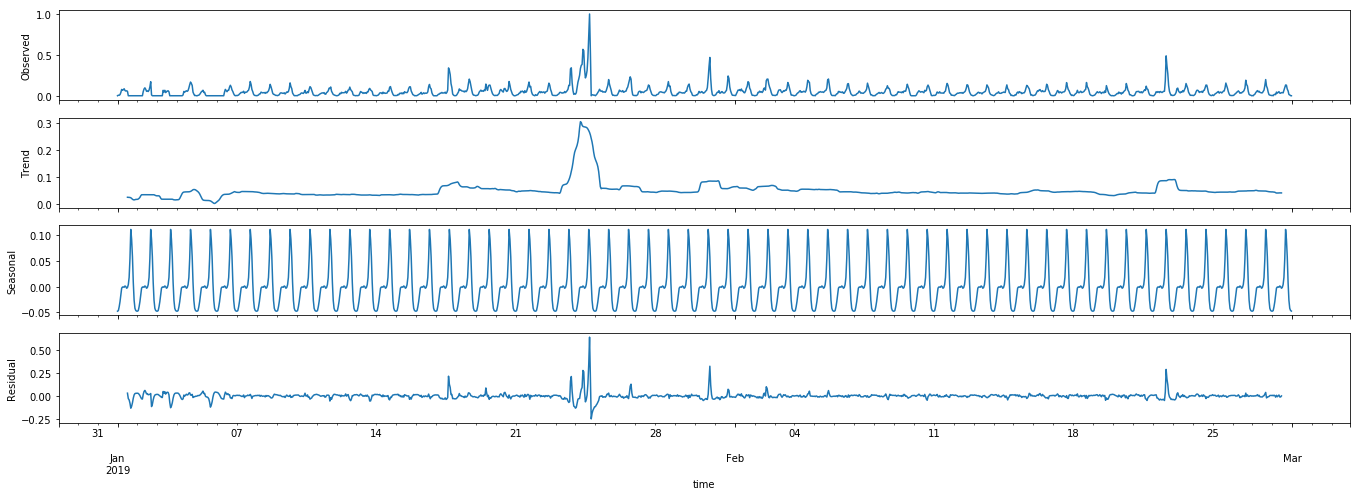

In [118]:
plt.rcParams['figure.figsize']=[19,7]
res = seasonal_decompose(train,model='additive')
resplot = res.plot()

It captures the seasonality.

Renaming column to be able to pass to fb prophet's algorithm

In [119]:
df = deposit_hour.reset_index().rename(index=str,columns={"amount":"y","time":"ds"})
train_fb = df[df.ds.dt.month<3]
test_fb = df[df.ds.dt.month==3]

Create instance of prophet and fit data 

In [120]:
m = Prophet()
m.fit(train_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Predict up to the following month even after two months passed

In [121]:
future = m.make_future_dataframe(periods=616,freq='H')
future.tail()

,ds
2027,2019-03-26 11:00:00
2028,2019-03-26 12:00:00
2029,2019-03-26 13:00:00
2030,2019-03-26 14:00:00
2031,2019-03-26 15:00:00


Make predictions

In [122]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2027,2019-03-26 11:00:00,0.052571,-0.036757,0.119523,0.006548,0.094503,-0.010676,-0.010676,-0.010676,-0.001158,-0.001158,-0.001158,-0.009518,-0.009518,-0.009518,0.0,0.0,0.0,0.041895
2028,2019-03-26 12:00:00,0.052580,-0.043185,0.115995,0.006420,0.094588,-0.017482,-0.017482,-0.017482,-0.007390,-0.007390,-0.007390,-0.010092,-0.010092,-0.010092,0.0,0.0,0.0,0.035098
2029,2019-03-26 13:00:00,0.052589,-0.037678,0.121445,0.006292,0.094673,-0.011830,-0.011830,-0.011830,-0.001198,-0.001198,-0.001198,-0.010632,-0.010632,-0.010632,0.0,0.0,0.0,0.040759
2030,2019-03-26 14:00:00,0.052598,-0.013208,0.139822,0.006164,0.094759,0.014311,0.014311,0.014311,0.025438,0.025438,0.025438,-0.011128,-0.011128,-0.011128,0.0,0.0,0.0,0.066909
2031,2019-03-26 15:00:00,0.052607,0.028375,0.183861,0.006046,0.094822,0.052866,0.052866,0.052866,0.064437,0.064437,0.064437,-0.011571,-0.011571,-0.011571,0.0,0.0,0.0,0.105472


Show forecast

Get the r2 score of the train and test

In [123]:
#extract train only
forecast_train  = forecast[forecast.ds.dt.month<3]

r2_score(train_fb.y,forecast_train.yhat)

0.46493678432187913

In [124]:
#extract test
forecast_test  = forecast[forecast.ds.dt.month==3]
r2_score(test_fb.y,forecast_test.yhat)

0.38866610172552862

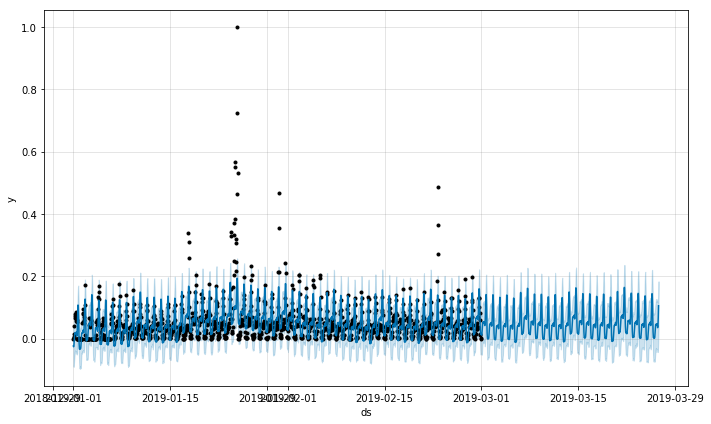

In [125]:
fig1 = m.plot(forecast)

### Classification Trees

Breakdown timestamp to other features so as to pass it to regressors i.e hour,day and day of the week

In [126]:
deposit_hour['hour'] = deposit_hour.index.hour
deposit_hour['week'] =  deposit_hour.index.week
deposit_hour['month'] =  deposit_hour.index.month
deposit_hour['day_of_week'] =  deposit_hour.index.dayofweek
deposit_hour.tail()

,amount,hour,week,month,day_of_week
time,,,,,
2019-03-26 11:00:00,0.085393,11,13,3,1
2019-03-26 12:00:00,0.092135,12,13,3,1
2019-03-26 13:00:00,0.074157,13,13,3,1
2019-03-26 14:00:00,0.114607,14,13,3,1
2019-03-26 15:00:00,0.015730,15,13,3,1


Create a train and test dataset of the decomposed timestamp dataframe

In [127]:
train_decompose = deposit_hour[deposit_hour.index.month<3]
test_decompose = deposit_hour[deposit_hour.index.month==3]

Create train and test matrices without y column to pass to regression models

In [128]:
X_train = train_decompose.drop(columns=['amount']) 
X_test = test_decompose.drop(columns=['amount']) 

y_train = train_decompose.amount
y_test = test_decompose.amount

Import libraries for the model

In [129]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
 
#these are the hyperparameters that yielded the best test results (no grid search)
clf = RandomForestRegressor(max_depth=7, random_state=15,n_estimators=22)
clf.fit(X_train, y_train) 

y_ = clf.predict(X_test)
y_pred = clf.predict(X_train)

#get r_score
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.649405264126 			 0.483278996477


Creating dataframe to plot predictions and actual with ease

In [130]:
#using test
predictions= test
predictions['predictions'] = y_

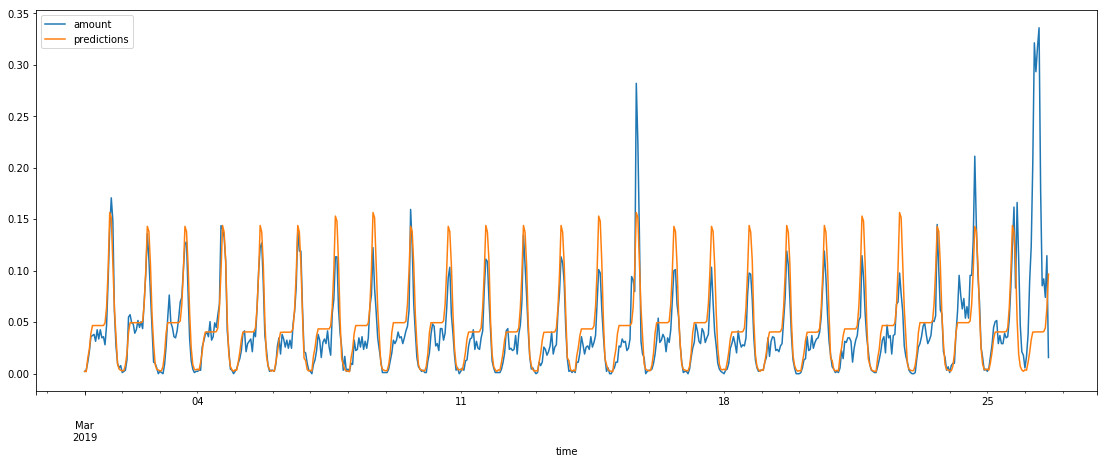

In [131]:
predictions.plot()

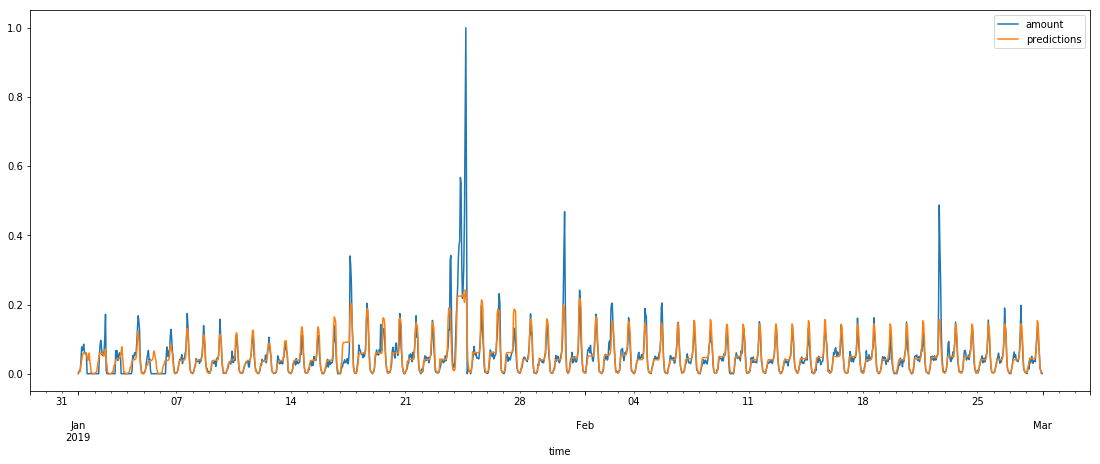

In [132]:
#using train
pred= train
pred['predictions'] = y_pred
pred.plot()

## KNN Regressor


In [133]:
from sklearn.neighbors import KNeighborsRegressor

#number of neighbours with best results (no grid search)
neigh = KNeighborsRegressor(n_neighbors=50)
neigh.fit(X_train, y_train) 
    
y_ = neigh.predict(X_test)
y_pred = neigh.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.483070939976 			 0.453413434511


## Linear Regression

In [134]:
from sklearn.linear_model import LinearRegression

#no tuning of hyperparameters
reg = LinearRegression().fit(X_train, y_train)
y_ = reg.predict(X_test)
y_pred = reg.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.0476040375688 			 0.0330769796949


## Stack Regressor

In [135]:
#Ensemble(stacking) for regressors (not sure how it works)
from mlxtend.regressor import StackingRegressor

#use the three algorithms
lr = LinearRegression()
rfr = RandomForestRegressor(max_depth=7, random_state=15,n_estimators=22)

neigh = KNeighborsRegressor(n_neighbors=50)
stregr = StackingRegressor(regressors=[rfr, lr, neigh], 
                           meta_regressor=neigh)

# Training the stacking classifier

stregr.fit(X_train, y_train) 

y_ = stregr.predict(X_test)
y_pred = stregr.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))


0.634090330732 			 0.51710771246


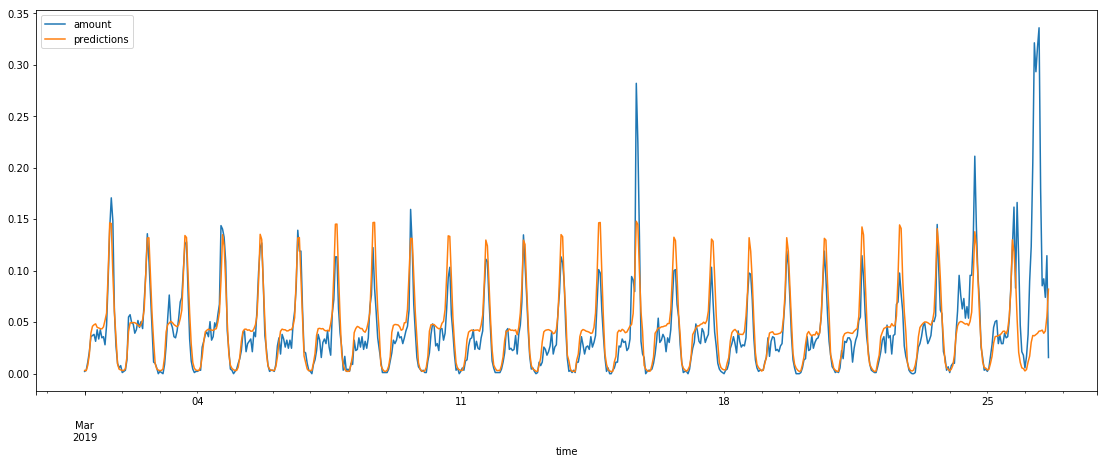

In [136]:
#using test
predictions= test
predictions['predictions'] = y_
predictions.plot()

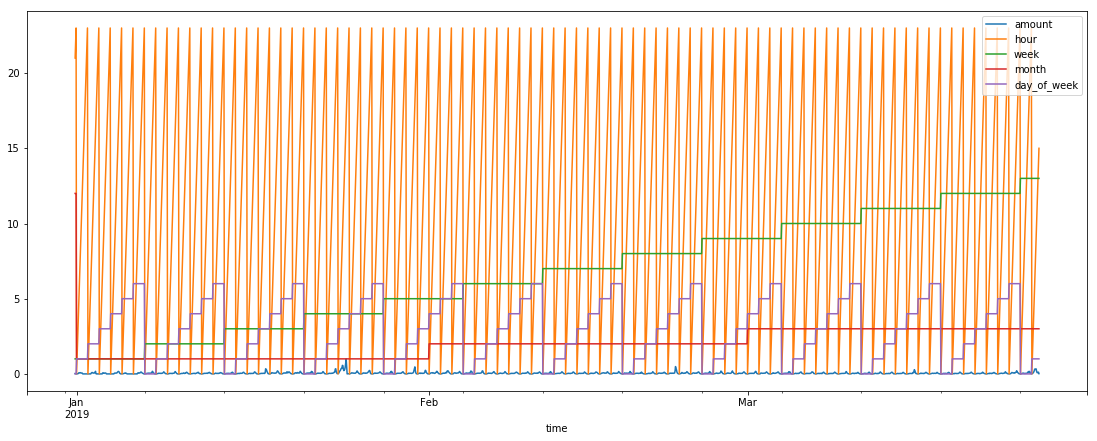

In [137]:
deposit_hour.plot()